# Model training

## 1. Preparing data

In [1]:
# Basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from xgboost import XGBClassifier

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

# Model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, roc_auc_score, recall_score

# Optimization and Model saving
import optuna
import joblib

# Utility and system related
import json
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the processed data
processed_data = pd.read_csv('../Dataset/processed_data.csv')

# Define feature columns
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_cols = ['gender', 'hypertension', 'heart_disease']
ordinal_cols = ['smoking_history']
target_col = 'diabetes'

# Create feature matrix X and target vector y
X = processed_data[numerical_cols + binary_cols + ordinal_cols]
y = processed_data[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

X shape: (59164, 8)
y shape: (59164,)


## 2. Optimizing and Evaluating XGBoost Model for Diabetes Prediction

In [3]:
# Optimize XGBoost with focus on recall
def objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),  # Added to handle class imbalance
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    # Changed scoring metric to 'recall'
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
    return scores.mean()

# Run optimization
print("Optimizing XGBoost for recall...")
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)  # Increased trials

# Train final model with best parameters
best_params = study.best_trial.params
print("\nBest parameters:", best_params)
print("Best cross-validation recall:", study.best_value)

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Model evaluation
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)
test_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
train_recall = recall_score(y_train, train_pred)
test_recall = recall_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)
accuracy = accuracy_score(y_test, test_pred)
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

# Summary statistics
print("\nModel Performance Summary:")
print("-" * 50)
print("\nDataset Information:")
print(f"Number of features used: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Positive class ratio - Train: {y_train.mean():.2%}")
print(f"Positive class ratio - Test: {y_test.mean():.2%}")

print("\nModel Performance Metrics:")
print(f"Best CV Recall Score: {study.best_value:.4f}")
print(f"Training Recall Score: {train_recall:.4f}")
print(f"Test Recall Score: {test_recall:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
    

[I 2024-11-30 15:27:09,175] A new study created in memory with name: no-name-766b7a3f-0cd7-49be-ba1f-3715268cfc0f


Optimizing XGBoost for recall...


[I 2024-11-30 15:27:09,879] Trial 0 finished with value: 0.8770459081836327 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.1824021797729484, 'min_child_weight': 7, 'subsample': 0.6835213671813365, 'scale_pos_weight': 7.052910506965456}. Best is trial 0 with value: 0.8770459081836327.
[I 2024-11-30 15:27:11,314] Trial 1 finished with value: 0.8181636726546907 and parameters: {'n_estimators': 355, 'max_depth': 5, 'learning_rate': 0.24645059848163273, 'min_child_weight': 1, 'subsample': 0.9668641265773226, 'scale_pos_weight': 9.214711648335483}. Best is trial 0 with value: 0.8770459081836327.
[I 2024-11-30 15:27:13,164] Trial 2 finished with value: 0.7357285429141718 and parameters: {'n_estimators': 280, 'max_depth': 8, 'learning_rate': 0.29070940149742436, 'min_child_weight': 1, 'subsample': 0.8543009905994299, 'scale_pos_weight': 1.4757493347272574}. Best is trial 0 with value: 0.8770459081836327.
[I 2024-11-30 15:27:14,263] Trial 3 finished with value: 0.78363


Best parameters: {'n_estimators': 176, 'max_depth': 4, 'learning_rate': 0.03550918925056938, 'min_child_weight': 7, 'subsample': 0.688338037139034, 'scale_pos_weight': 9.522987138712402}
Best cross-validation recall: 0.9283433133732535

Model Performance Summary:
--------------------------------------------------

Dataset Information:
Number of features used: 8
Training samples: 47331
Test samples: 11833
Positive class ratio - Train: 10.59%
Positive class ratio - Test: 10.59%

Model Performance Metrics:
Best CV Recall Score: 0.9283
Training Recall Score: 0.9311
Test Recall Score: 0.9306
Test Precision: 0.4670
Test F1 Score: 0.6219
Test Accuracy: 0.8802
ROC AUC Score: 0.9759

Best Hyperparameters:
n_estimators: 176
max_depth: 4
learning_rate: 0.03550918925056938
min_child_weight: 7
subsample: 0.688338037139034
scale_pos_weight: 9.522987138712402


Comment -
- For diabetes prediction, we focused on catching as many real diabetes cases as possible (93% success) by using Recall metrics in training. 
- While this leads to more false alarms, it's safer for patients since missing diabetes is more dangerous than doing extra medical tests.

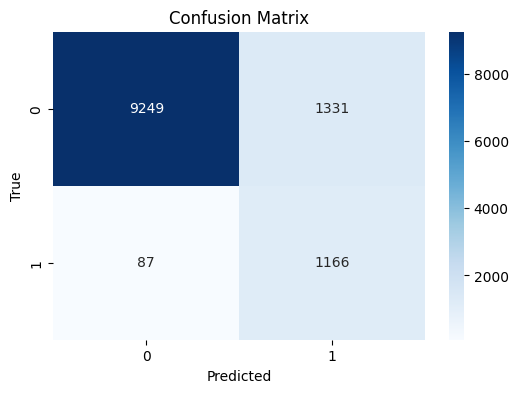

In [4]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Insight - 
- The confusion matrix shows that our recall-focused model successfully caught most diabetes cases (1,166 true positives with only 87 missed cases), though it also flagged many healthy people for additional testing (1,1331 false positives). 
- This aligns with our goal of prioritizing patient safety by minimizing missed diabetes cases, even if it means more healthy people need further testing.

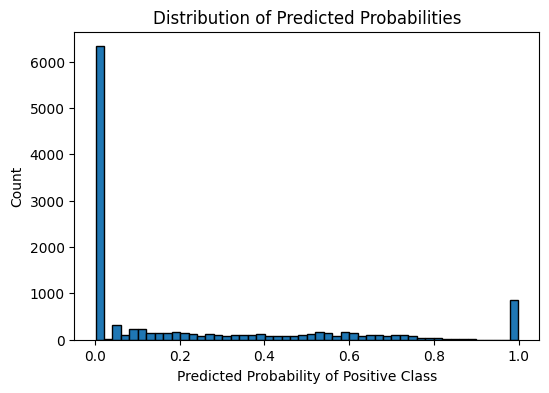

In [5]:
# Plot predicted probabilities distribution
plt.figure(figsize=(6, 4))
plt.hist(test_probs, bins=50, edgecolor='black')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Count')
plt.show()

Insight -
- The probability distribution shows that the model is very confident when predicting most non-diabetic cases (large spike near 0) and also shows high confidence for clear diabetes cases (spike near 1.0). 
- The scattered predictions in between represent cases where the model is less certain, which is normal in medical diagnoses.

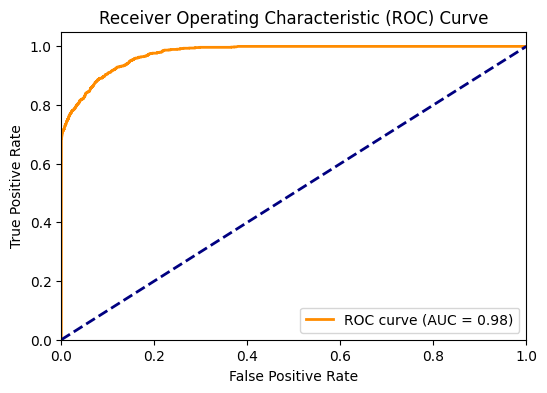

In [6]:
# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Insight -
- The ROC curve with an AUC score of 0.97 shows that our model is excellent at distinguishing between diabetic and non-diabetic cases. 
- The high curve (far above the diagonal dotted line) indicates strong performance, with the model achieving a high true positive rate (finding real diabetes cases) while keeping false positives relatively low at different probability thresholds.

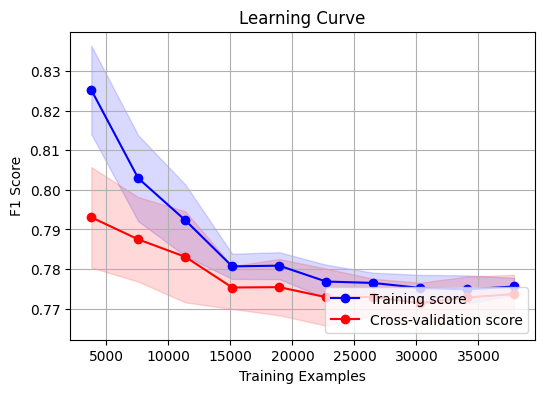

In [7]:
# Plot learning curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='f1_macro', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Insight - 
- The learning curve shows that the model's F1 scores for both training and cross-validation converge around 0.77, with the gap between them being small. 
- This indicates that our model is well-balanced, without overfitting or underfitting issues, and adding more training data likely wouldn't significantly improve performance since both scores have stabilized.

In [8]:
# Create results summary dictionary
results_summary = {
    'dataset_info': {
        'n_features': X_train.shape[1],
        'n_train_samples': X_train.shape[0],
        'n_test_samples': X_test.shape[0],
        'train_pos_ratio': float(y_train.mean()),
        'test_pos_ratio': float(y_test.mean())
    },
    'best_params': best_params,
    'performance_metrics': {
        'best_cv_recall': float(study.best_value),
        'train_recall': float(train_recall),
        'test_recall': float(test_recall),
        'test_precision': float(precision),
        'test_f1': float(f1),
        'test_accuracy': float(accuracy),
        'test_roc_auc': float(roc_auc)
    }
}

# Path to existing artifact directory and create models subdirectory
BASE_PATH = '../artifact'  # Assuming notebooks are in 'notebook' directory
models_dir = os.path.join(BASE_PATH, 'models')
os.makedirs(models_dir, exist_ok=True)

# Get current timestamp for versioning
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Save the trained model
model_filename = os.path.join(models_dir, f'diabetes_model_{timestamp}.joblib')
joblib.dump(best_model, model_filename)
print(f"\nModel saved to: {model_filename}")

# Save model parameters and performance metrics
results_filename = os.path.join(models_dir, f'model_results_{timestamp}.json')
with open(results_filename, 'w') as f:
    json.dump(results_summary, f, indent=4)
print(f"Results saved to: {results_filename}")

# Save feature names for future reference
feature_info = {
    'numerical_features': numerical_cols,
    'binary_features': binary_cols,
    'ordinal_features': ordinal_cols,
    'target_column': target_col
}
features_filename = os.path.join(models_dir, f'feature_info_{timestamp}.json')
with open(features_filename, 'w') as f:
    json.dump(feature_info, f, indent=4)
print(f"Feature information saved to: {features_filename}")


Model saved to: ../artifact\models\diabetes_model_20241130_152755.joblib
Results saved to: ../artifact\models\model_results_20241130_152755.json
Feature information saved to: ../artifact\models\feature_info_20241130_152755.json
